In [10]:
import time
from tqdm import tqdm
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import cProfile
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings("ignore")

def dropout_layer(X, dropout):
    assert 0<= dropout<= 1
    if dropout == 1:
        return torch.zeros_like(X)
    mask = (torch.randn(X.shape)>dropout).float()
    return mask * X /(1-dropout)

class DropoutMLPScratch(d2l.MulMLPScratch):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, dropouts, sigma=0.01):
        super().__init__(num_inputs, num_outputs, num_hiddens, lr, sigma=0.01)
        self.save_hyperparameters()
        
    def forward(self, X):
        H = X.reshape(-1, self.num_inputs)
        for i in range(len(self.W)-1):
            H = d2l.relu(torch.matmul(H, self.W[i]) + self.b[i])
            if self.training:
                H = dropout_layer(H, self.dropouts[i])
                
        return torch.matmul(H, self.W[-1]) + self.b[-1]
    

class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for i in range(len(num_hiddens)):
            layers.append(nn.LazyLinear(num_hiddens[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)
    

acc: 0.66


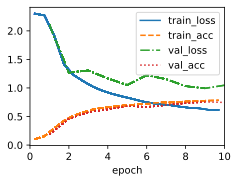

In [12]:
hparams = {'num_outputs':10, 'num_inputs':28*28, 'num_hiddens':[256]*2,
           'dropouts':[0.5]*2,'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32)) 
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

acc: 0.78


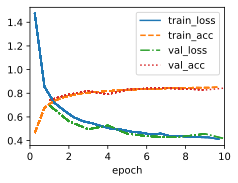

In [13]:
hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':[0.5]*2,'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32)) 
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

# 1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.

In [15]:
def stat_dropout(dropouts):
    hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':dropouts,'lr':0.1}
    model = DropoutMLP(**hparams)
    trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32)) 
    return model.accuracy(y_hat,data.val.targets).item()

dropout_list = [[0.1,0.5],[0.5,0.1],[0.1,0.9],[0.9,0.1]]
accs = []
for dropouts in tqdm(dropout_list):
    accs.append(stat_dropout(dropouts))

100%|██████████| 4/4 [10:39<00:00, 159.81s/it]


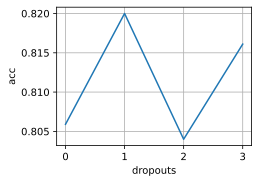

In [18]:
d2l.plot(list(range(len(dropout_list))),accs[-len(dropout_list):],'dropouts','acc')

# 2. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.

In [19]:
def stat_epoch(dropouts,epochs):
    hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':dropouts,'lr':0.1}
    model = DropoutMLP(**hparams)
    trainer = d2l.Trainer(max_epochs=epochs, plot_flag=False)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32)) 
    return model.accuracy(y_hat,data.val.targets).item()

dropout_list = [[0.5,0.5],[0,0]]
epoch_list = [5,10,20]
accs = [[0]*len(epoch_list) for i in range(2)]
for i in tqdm(range(len(epoch_list))):
    for j in range(len(dropout_list)):
        accs[j][i] = stat_epoch(dropout_list[j], epoch_list[i])

100%|██████████| 3/3 [18:35<00:00, 371.90s/it]


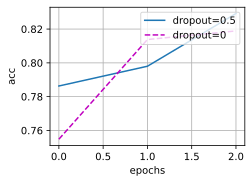

In [20]:
d2l.plot(list(range(len(epoch_list))),[accs[0],accs[1]],'epochs','acc',legend=['dropout=0.5','dropout=0'])

# 3. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.

In [76]:
class PlotActMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        self.activations = []
        for i in range(len(num_hiddens)):
            layers.append(nn.LazyLinear(num_hiddens[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
            self.activations.append(i*3+4)
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)
        
    def training_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        if plot_flag:
            for i in self.activations:
                for j in range(2):
                    var = self.stat_activation_variance(i-j, *batch[:-1])
                    self.plot(f'layer_{i-j}',var,train=True)
            # self.plot('loss', self.loss(y_hat, batch[-1]), train=True)
            # self.plot('auc', auc, train=True)
            # self.plot('acc', self.accuracy(y_hat, batch[-1]), train=True)
        return self.loss(y_hat, batch[-1])
        
    def validation_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        # if plot_flag:
            # self.plot('loss', self.loss(y_hat, batch[-1]), train=False)
            # self.plot('auc', auc, train=True)
            # self.plot('acc', self.accuracy(y_hat, batch[-1]), train=False)
        return self.loss(y_hat, batch[-1])
    
    def stat_activation_variance(self, i, X):
        activation = self.net[:i](X)
        return ((activation-activation.mean(axis=0,keepdim=True))**2).mean()

In [74]:
model.net

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

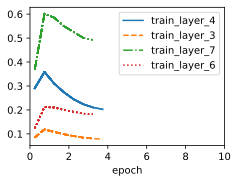

In [ ]:
hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':[0.5]*2,'lr':0.1}
model = PlotActMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

KeyboardInterrupt: 

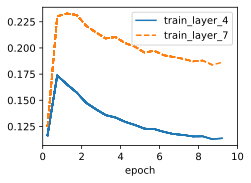

In [71]:
hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':[0]*2,'lr':0.1}
model = PlotActMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 4. Why is dropout not typically used at test time?

Dropout is a regularization technique commonly used during the training phase of a neural network to prevent overfitting. However, it's not typically used at test time for a couple of important reasons:

1. **Inference vs. Training:**
   During training, dropout works by randomly deactivating a fraction of neurons in each layer with a certain probability. This process helps prevent the network from relying too heavily on specific neurons and encourages the network to learn more robust and generalized features. During inference (test time), the goal is to make predictions on new, unseen data, and dropout doesn't serve the same purpose. Applying dropout at test time would introduce randomness into the predictions, which is undesirable.

2. **Deterministic Predictions:**
   At test time, you want the neural network to produce deterministic predictions so that you can compare and evaluate the model's performance consistently. Dropout introduces randomness into the network's activations, which leads to different predictions every time the same input is passed through the network. This makes it challenging to interpret and evaluate the model's predictions reliably.

3. **Scaling Neuron Outputs:**
   During training, dropout deactivates neurons and scales their outputs by the inverse of the dropout probability. This scaling compensates for the fact that some neurons are dropped out during each forward pass. However, during inference, this scaling is not applied, leading to different magnitudes of neuron outputs. This inconsistency can affect the model's predictions and make them less reliable.

4. **Ensemble Behavior:**
   Dropout can be viewed as training an ensemble of multiple sub-networks by randomly dropping neurons. During inference, using all the sub-networks for prediction would be computationally expensive and might not provide a clear advantage over other methods of model averaging.

5. **Alternative Techniques:**
   While dropout is effective during training, there are other techniques that achieve similar goals during inference without introducing randomness. Techniques like batch normalization and weight scaling can help stabilize the network's activations and ensure consistent and deterministic predictions.

In summary, dropout is not used at test time to maintain the deterministic and reliable nature of predictions. The main goal of dropout is to improve the generalization of the model by preventing overfitting during training. Once the model is trained, the focus shifts to making accurate and consistent predictions on new data, which dropout's randomness can hinder.

# 5. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?

# 6. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?

# 7. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?